<a href="https://colab.research.google.com/github/adrianrusu16/cvdl/blob/main/Copy_of_Computer_Vision_and_Deep_Learning_Laboratory_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision and Deep Learning - Laboratory 6
 
Congratulations, you made it till the last laboratory of the semester. This laboratory will be a bit different: it contains two parts and you can __choose__ at your own preference which of them you want to solve.  Of course, you can choose to solve both of them.
 
The first part is related to _visualization_, while the second one is related to sequence models and vision transformers.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Part 1. Visualizing what neural networks learn



For this part you can either work with a neural network that you trained (perhaps for your project), or with a pre-trained model from tensorflow.
 
For illustration purposes, I will load the Resnet network, pre-trained on Imagenet and, of course, an image of a cat.


--2021-12-09 06:43:40--  https://img.freepik.com/free-photo/cat-white-background_155003-20502.jpg?size=626
Resolving img.freepik.com (img.freepik.com)... 23.200.149.225, 2600:140e:6:bbf::30ec, 2600:140e:6:b8d::30ec
Connecting to img.freepik.com (img.freepik.com)|23.200.149.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25662 (25K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  25.06K  --.-KB/s    in 0.01s   

2021-12-09 06:43:41 (1.90 MB/s) - ‘cat.jpg’ saved [25662/25662]



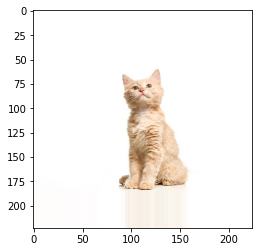

In [ ]:
!wget -O cat.jpg https://img.freepik.com/free-photo/cat-white-background_155003-20502.jpg?size=626&ext=jpg

img = cv2.imread('cat.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
factor = 224.0/img.shape[1]
img = cv2.resize(img, None, fx=factor, fy=factor)
if img.shape[0] > img.shape[1]:
  img = cv2.copyMakeBorder(img, top=0, bottom=0, left=(img.shape[0] - img.shape[1])//2, right=(img.shape[0] - img.shape[1])//2,
                          borderType=cv2.BORDER_REPLICATE)
else:
    img = cv2.copyMakeBorder(img, top=(img.shape[1] - img.shape[0])//2, bottom=(img.shape[1] - img.shape[0])//2, left=0, right=0,
                          borderType=cv2.BORDER_REPLICATE)


plt.imshow(img)

In [ ]:
resnet50_model = ResNet50(weights='imagenet')
resnet50_model.summary()
#tf.keras.utils.plot_model(resnet50_model, show_shapes=True, show_dtype=True)

## Display the filters in the first and second convolutional layer

Get the filters in the first and second convolutional layers and plot them. The filters in the first convolutional layer should be displayed as color images, while for the filters in the second layer you should display each channel individually as a grayscale image.

Identify the names of these two layers and then use _layer.get_weights()_ to access the values of the filters.

In [ ]:
# TODO your code here
layer1_weights = resnet50_model.get_layer("conv1_conv").get_weights()[0]
mn = np.min(layer1_weights)
layer1_weights -= mn
mx = np.max(layer1_weights)
layer1_weights /= mx
layer1_weights *= 255
layer1_weights = layer1_weights.astype(int)
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(layer1_weights[:, :, :, i])
plt.tight_layout()
plt.show()

layer1_weights = resnet50_model.get_layer("conv2_block1_1_conv").get_weights()[0].reshape((8, 8, 64))
mn = np.min(layer1_weights)
layer1_weights -= mn
mx = np.max(layer1_weights)
layer1_weights /= mx
layer1_weights *= 255
layer1_weights = layer1_weights.astype(int)
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(layer1_weights[:, :, i], cmap="gray")
plt.tight_layout()
plt.show()

## Saliency map via image occlusions
 
This visualization technique will output a heatmap which will highlight the regions that the model finds important when predicting a certain class.
 
The implementation is straightforward: you just slide an occluding patch over the input image, and, for each position of the patch, feed the occluded image to the network and store the predictions (probas) of the model.
 
Finally, display (as a heatmap) the probability of the correct class.


In [ ]:
def compute_saliency_map(model, img, patch_size, stride):
    """
    Succesivelly occlude the input image with a gray square patch of size patch_size.
    When sliding the patch over the input image a step equal to stride is used.
    """

    padded_image = np.pad(img, ((patch_size//2, patch_size//2), (patch_size//2, patch_size//2), (0, 0)), mode="edge")

    # TODO your code here: compute the size of the output
    wo = int((img.shape[1] + 2*(patch_size//2))/stride + 1) # the width of the output heatmap
    ho = int((img.shape[0] + 2*(patch_size//2))/stride + 1) # the height of the output heatmap
    heatmap = np.zeros((ho, wo), dtype=np.float32)

    true_class = tf.keras.backend.get_value(model(np.expand_dims(tf.keras.applications.resnet50.preprocess_input(img), 0)))
    print(tf.keras.applications.resnet50.decode_predictions(true_class))
    true_class = np.argmax(true_class, axis=-1)[0]
    batch = []

    for y in range(0, ho, stride):
        for x in range(0, wo, stride):
            patched_image = np.copy(img)
            patched_image[y*stride-patch_size//2:y*stride+patch_size//2,x*stride-patch_size//2:x*stride+patch_size//2, :] = 128
            batch.append(patched_image)
    pred = model.predict(np.asarray(batch), batch_size=32)
    print(pred.shape)
    print(true_class)
    scores = pred[:, true_class]
    heatmap = np.reshape(scores, (int(np.sqrt(scores.shape[0])), int(np.sqrt(scores.shape[0]))))
    return heatmap

heatmap = compute_saliency_map(resnet50_model, img, 32, 4)
# mn = np.min(heatmap)
# mx = np.max(heatmap)
# heatmap -= mn
# heatmap /= (mx-mn)
# heatmap *= 255
# heatmap = heatmap.astype(int)
plt.subplot(1, 2, 1)
plt.imshow(heatmap)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.show()

## Saliency maps via image derivative
 
This type of visualization tries to determine the pixels that contributed the most in the final classification.
The main idea is to compute the derivative of the scores with respect to the input image. This derivative can be seen as a class saliency map for the input image (its magnitude tells us what pixels should be modified to change the class score the most).
 
You can use a [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to compute the gradients.

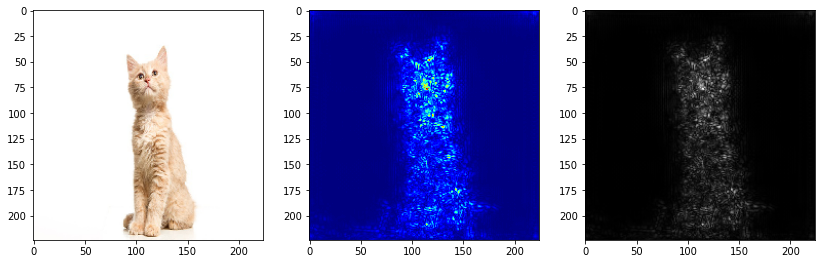

In [ ]:
import tensorflow.keras as keras

def compute_saliency_map(model, img):
  
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    img = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        pred = model(img, training=False)
        loss = pred[0, np.argmax(pred, axis=-1)[0]]
        grads = tape.gradient(loss, img)
        abs_grad = np.abs(grads)
        max_abs_grad = np.max(abs_grad, axis=3)

        # TODO your code here: normalize to range between 0 and 1
        mn = np.min(max_abs_grad)
        grad_norm = (max_abs_grad - mn)/(np.max(max_abs_grad) - mn)
    return grad_norm


model = tf.keras.applications.mobilenet_v2.MobileNetV2()
saliency_map = compute_saliency_map(model, img)

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].imshow(img)
ax[1].imshow(saliency_map[0, :, :],cmap="gray")

## t-SNE visualization (optional)

You can use the ImageNetes Apply t-SNE visualization on the last layer of the network that you chose.
You can use the [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) module from sklean library.

To create this visualization, you will need several images and their ground truth class. You could use some images from [imagenette](https://github.com/fastai/imagenette).

Feed the images through your model and save the activation maps of the layer just before the classification layer (create a new model starting from the pre-trained architecture that you used and set that layer as the input). Then, use t-SNE visualization to view the classes (the colors of the points should be determined by the class of those images).

# Deep-dream

Follow this [tutorial](https://www.tensorflow.org/tutorials/generative/deepdream) related to DeepDream.

98304/83281 [===================================] - 0s 0us/step


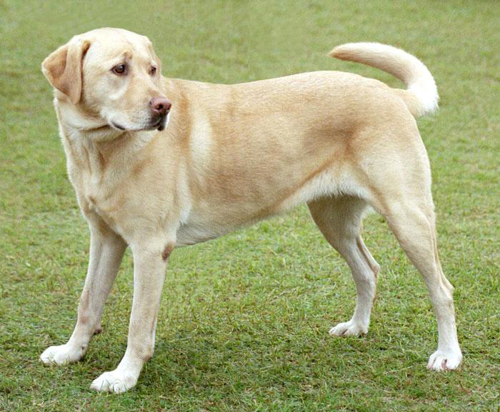

In [13]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [14]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [15]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [16]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [17]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [18]:
deepdream = DeepDream(dream_model)

In [19]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

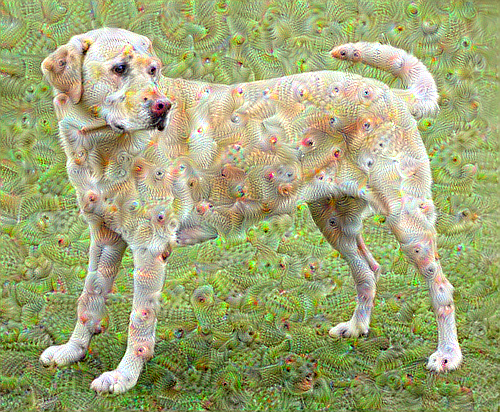

In [20]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

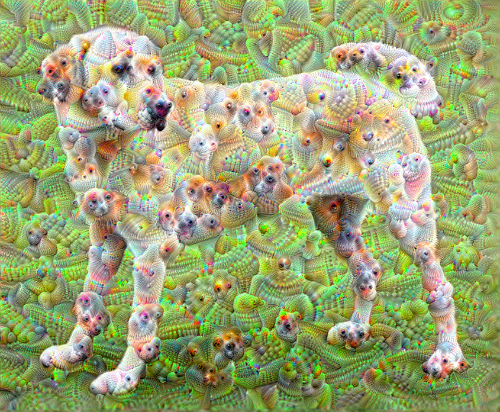

328.30576181411743

In [21]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

In [22]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

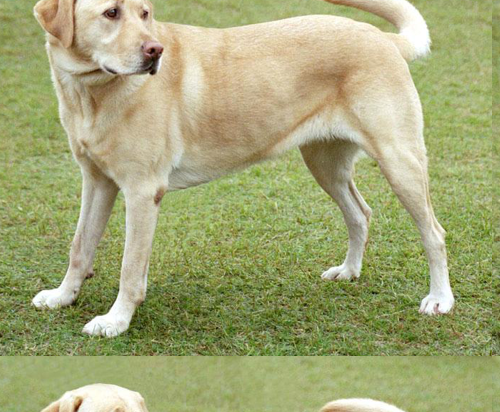

In [23]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [24]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [25]:
get_tiled_gradients = TiledGradients(dream_model)

In [26]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

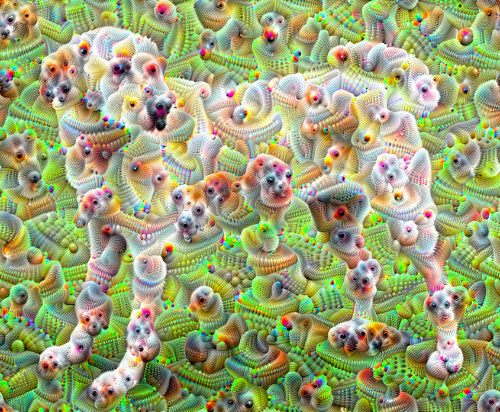

In [27]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

# Part 2. Sequence models and image transformers



## Text generation at character level


Data processing 

- Load the training data [Poezii Eminescu.txt](https://ubbcluj.sharepoint.com/:t:/s/CVDL2021/EYeZJEN0aKNBs7xVblsELwgBaIpG7lF7VzDoMKs6fx7w0Q?e=QacxxQ) and determine the vocabulary for this problem 

- Encode the characters into a numerical representation: you should assign an id (number) for each character and, also, you should be able to determine retrieve the corresponding character of a given id 

- Split the training data into overlapping sequences of size _seq\_size_ . X will be an array of  _seq\_size_ from the text and the y (ground truth) will be the character that follows that sequence.

- Transform the data to one hot encoding 

Model creation 

- Build a simple recurrent network: input layer, LSTM layer, dense layer  (softmax activation) 

Training 

- Compile and train the model (categorical_crossentropy loss) 

- Use ModelCheckpoint callback to save the model https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint  

Text generation 

- Create a text sampling method: you could use a multinomial distribution to  sample the index of the next character from the softmax probas: 

https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html  

``
next_character = argmax(np.random.multinomial(1, preds)) 
``

Experiment with the temperature of softmax

Follow this [tutorial](https://keras.io/examples/vision/image_classification_with_vision_transformer/) about image transformers.


In [2]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.3 MB/s 


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


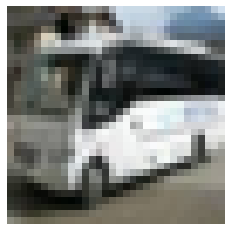

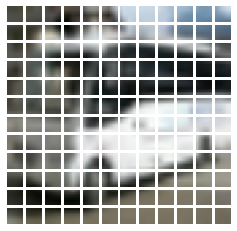

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [10]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 2455s 14s/step - loss: 4.4895 - accuracy: 0.0428 - top-5-accuracy: 0.1525 - val_loss: 3.9835 - val_accuracy: 0.0898 - val_top-5-accuracy: 0.2844
Epoch 2/100
176/176 [==============================] - 2351s 13s/step - loss: 3.9728 - accuracy: 0.0917 - top-5-accuracy: 0.2816 - val_loss: 3.6259 - val_accuracy: 0.1504 - val_top-5-accuracy: 0.3902
Epoch 3/100
176/176 [==============================] - 2332s 13s/step - loss: 3.7243 - accuracy: 0.1266 - top-5-accuracy: 0.3566 - val_loss: 3.3486 - val_accuracy: 0.1904 - val_top-5-accuracy: 0.4618
Epoch 4/100
176/176 [==============================] - 2333s 13s/step - loss: 3.5364 - accuracy: 0.1584 - top-5-accuracy: 0.4140 - val_loss: 3.2156 - val_accuracy: 0.2184 - val_top-5-accuracy: 0.5044
Epoch 5/100
 81/176 [============>.................] - ETA: 20:20 - loss: 3.3979 - accuracy: 0.1791 - top-5-accuracy: 0.4499